In [ ]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import librosa
import random
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/woongjae/XAI')
from SSL_aasist.model import Model

import librosa
import random
from sklearn.linear_model import Ridge
from sklearn.metrics.pairwise import cosine_distances

In [2]:
def evaluate_single_audio(model, audio_path, device="cpu", sr=16000):
    """
    단일 오디오 파일을 모델에 넣어 real/fake 확률과 예측 레이블 반환
    Args:
        model: 학습된 PyTorch 모델
        audio_path (str): wav 파일 경로
        device (str): "cpu" 또는 "cuda"
        sr (int): 리샘플링할 샘플링 레이트 (기본=16000)
    
    Returns:
        dict: {
            "file": 파일 경로,
            "pred": 0=bonafide, 1=spoof,
            "real_score": bonafide 확률,
            "fake_score": spoof 확률
        }
    """
    # 오디오 불러오기
    waveform, _ = librosa.load(audio_path, sr=sr)
    waveform = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0).to(device)  # [1, T]

    # 추론
    model.eval()
    with torch.no_grad():
        output = model(waveform)  # [1, 2]
        prob = F.softmax(output, dim=1)
        pred = torch.argmax(prob, dim=1).item()
        score_real = prob[0, 0].item()
        score_fake = prob[0, 1].item()

    return {
        "file": audio_path,
        "pred": pred,
        "real_score": score_real,
        "fake_score": score_fake
    }

### frame-level masking

In [ ]:
def segment_waveform_frames(waveform, sr=16000, frame_ms=100):
    """
    waveform을 frame_ms(ms) 단위로 segment 분할
    return: [(start_sample, end_sample), ...]
    """
    if isinstance(waveform, torch.Tensor):
        num_samples = waveform.shape[-1]
    else:
        num_samples = len(waveform)

    seg_len = int(sr * frame_ms / 1000)
    segments = []
    for start in range(0, num_samples, seg_len):
        end = min(start + seg_len, num_samples)
        segments.append((start, end))
    return segments, seg_len

def mask_waveform(waveform, segments, mask_idx):
    """
    특정 segment index들을 마스킹 (0으로 대체)
    """
    masked = waveform.clone()
    for idx in mask_idx:
        start, end = segments[idx]
        masked[0, start:end] = 0.0
    return masked

In [ ]:
def generate_lime_samples(model, waveform, segments, num_samples=200, device="cpu", use_logit=True, p_mask=0.5):
    """
    LIME용 샘플 생성 및 모델 점수 기록
    """
    model.eval()
    # 원본 예측
    with torch.no_grad():
        output = model(waveform.to(device))  # [1,2]
        prob = torch.softmax(output, dim=1)
        pred = torch.argmax(prob, dim=1).item()
        base_score = output[0, pred].item() if use_logit else prob[0, pred].item()

    print(f"[Baseline] pred={pred} ({'real' if pred==0 else 'spoof'}), score={base_score:.6f}")

    X, y = [], []
    S = len(segments)

    for _ in range(num_samples):
        mask_idx = [i for i in range(S) if np.random.rand() < p_mask]
        x_vec = np.ones(S, dtype=np.float32)
        if mask_idx:
            x_vec[mask_idx] = 0.0

        masked_wave = mask_waveform(waveform, segments, mask_idx).to(device)

        with torch.no_grad():
            out = model(masked_wave)
            score = out[0, pred].item() if use_logit else torch.softmax(out, dim=1)[0, pred].item()

        X.append(x_vec)
        y.append(score)

    X = np.array(X)
    y = np.array(y)
    print(f"[LIME] Generated dataset: X={X.shape}, y={y.shape}")
    return X, y, base_score, pred

In [ ]:
def fit_weighted_surrogate(X, y, base_vec, sigma=0.25):
    """
    Weighted Ridge surrogate with cosine similarity kernel
    """
    D = cosine_distances(X, base_vec.reshape(1, -1)).ravel()
    W = np.exp(-(D**2) / (sigma**2))

    surrogate = Ridge(alpha=1.0, fit_intercept=True)
    surrogate.fit(X, y, sample_weight=W)
    return surrogate, W

In [ ]:
def plot_waveform_with_frame_importance(
    waveform, importances, sr=16000, segments=None, top_ratio=0.1, title="Frame-level LIME Importance"
):
    """
    frame-level 중요도 시각화 (상위 top_ratio 강조)
    """
    if isinstance(waveform, torch.Tensor):
        waveform = waveform.squeeze().cpu().numpy()

    T = len(waveform)
    times = np.arange(T) / sr
    num_segments = len(importances)

    # 중요도 절댓값 기준 상위 segment index
    k = max(1, int(num_segments * top_ratio))
    top_idx = np.argsort(np.abs(importances))[-k:]

    plt.figure(figsize=(14, 4))
    plt.plot(times, waveform, color="black", linewidth=0.8)
    ymin, ymax = plt.ylim()

    if segments is not None:
        for idx in top_idx:
            start, end = segments[idx]
            s_t, e_t = start / sr, end / sr
            plt.axvspan(s_t, e_t, color="red", alpha=0.3)

    plt.title(title)
    plt.ylabel("Amplitude")
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sr = 16000

model_path = "/home/woongjae/XAI/SSL_aasist/Best_LA_model_for_DF.pth"
audio_path = "/home/woongjae/XAI/LIME/myaudio_2.wav"

# ---- 모델 로드 (형 코드와 동일) ----
model = Model(None, device)
model = nn.DataParallel(model).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("Model loaded:", model_path)

# ---- Baseline 예측 + waveform 준비 ----
result, waveform = evaluate_single_audio(model, audio_path, device=device, sr=sr)
print("[Eval] ", result)

# ---- Segment into frames (e.g., 100ms) ----
segments, seg_len = segment_waveform_frames(waveform, sr=16000, frame_ms=100)
print(f"Total frame segments: {len(segments)}")

# ---- Generate LIME samples ----
X, y, base_score, pred = generate_lime_samples(
    model, waveform, segments, num_samples=500, device=device, use_logit=True, p_mask=0.3
)

# ---- Train surrogate ----
base_vec = np.ones(X.shape[1], dtype=np.float32)
surrogate, W = fit_weighted_surrogate(X, y, base_vec, sigma=0.25)
importances = surrogate.coef_

### visualization LIME on waveform

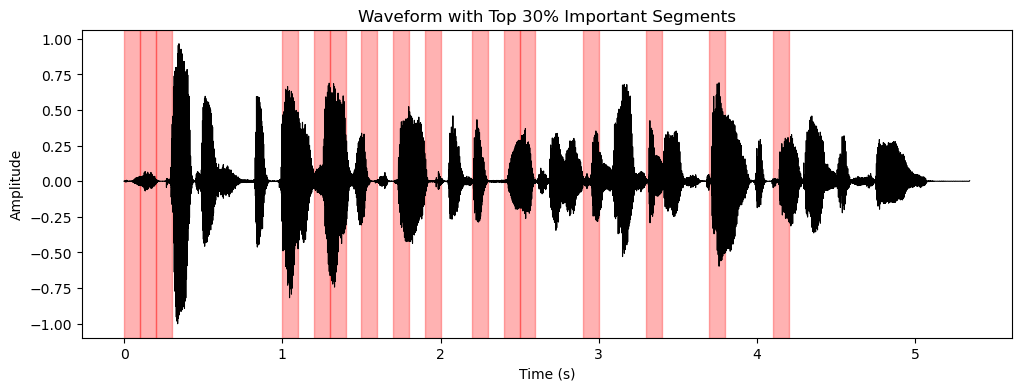

In [ ]:
plot_waveform_with_frame_importance(waveform, importances, sr=16000, segments=segments, top_ratio=0.1)